# Boostrapping error metrics for SAMPL5

This notebook reads in SAMPL5 submission data, performs bootstrapping on the uncertainties, and plots the results. This file needs the following directory structure and will write pickles of the results if `run_calculation = True` or read pickles of the results if `run_calculation = False`.
```    
.
├── Calc-CB
│   ├── BAR-ab-initio.txt
│   ├── BAR-dock.txt
│   ├── BEDAM.txt
│   ├── CBClip-absolute.pickle (will be created if missing)
│   ├── MovTyp-1.txt
│   ├── MovTyp-2.txt
│   ├── Null1.txt
│   ├── Null2.txt
│   ├── SOMD-1.txt
│   ├── SOMD-2.txt
│   ├── SOMD-3.txt
│   ├── SOMD-4.txt
│   ├── TI-ab-initio.txt
│   ├── TI-dock.txt
│   └── TIxBar.txt
├── Calc-OA
│   ├── APR-OPC.txt
│   ├── APR-TIP3P.txt
│   ├── BEDAM.txt
│   ├── CCSD(T)-neutral.txt
│   ├── DFT-charged.txt
│   ├── DFT-neutral.txt
│   ├── Metadynamics.txt
│   ├── MMPBSA-GAFF.txt
│   ├── MMPBSA-OPLS.txt
│   ├── MovTyp-1.txt
│   ├── MovTyp-2.txt
│   ├── Null1.txt
│   ├── Null2.txt
│   ├── OAH-OAMe-absolute.pickle (will be created if missing)
│   ├── OAH-OAMe-relative.pickle (will be created if missing)
│   ├── PERT-bound-c.txt
│   ├── PERT-bound.txt
│   ├── PERT-combo.txt
│   ├── PERT-hrex-c1.txt
│   ├── PERT-hrex-c2.txt
│   ├── PERT-hrex-c.txt
│   ├── PERT-hrex.txt
│   ├── SOMD-1.txt
│   ├── SOMD-2.txt
│   ├── SOMD-3.txt
│   └── SOMD-4.txt
├── SAMPL5-error-metrics.ipynb (this file)
└── Exp
    ├── CBClip.txt
    ├── OAAllAvg.txt
    ├── OAEnth10.txt
    └── OASaltDep.txt
```

In [1]:
!date

Wed Jun 22 10:19:46 PDT 2016


In [2]:
import sys,re
import numpy as np
from scipy import stats
import matplotlib as mpl 
import matplotlib.pyplot as plt
# Wrangle the data
import pandas as pd
# Nice figures
import seaborn as sns
# Access data
import os
# Save the results of bootstrapping
import pickle

%matplotlib inline
# LaTeX
mpl.rc('text', usetex=True)
# amsmath for \text{}
# helvetic to for Helvetica font
# sansmath to make math in Helvetica
mpl.rcParams['text.latex.preamble'] = [
       r'\usepackage{amsmath}',
       r'\usepackage{helvet}',    
       r'\usepackage{sansmath}',  
       r'\sansmath',
       r'\renewcommand{\familydefault}{\sfdefault}',
       r'\usepackage[T1]{fontenc}',
       r'\usepackage{graphicx}'
]

/data/davids4/anaconda3/lib/python3.5/site-packages/pandas/computation/__init__.py:19: UserWarning: The installed version of numexpr 2.4.4 is not supported in pandas and will be not be used

  UserWarning)


## Function definitions for setting the error metrics, reading the data, performing bootstrap analysis, and plotting the results.

In [3]:
def geterrormetrics(x, y, Nm):
    """
    Returns an array MTmp that stores the output of the error metrics on data given in (x, y).
    Written by Niel.
    """
    MTmp = np.zeros([Nm], np.float64)
    # Slope, Intercept, R
    Slp, MTmp[1], MTmp[2], pval, stderr = stats.linregress(x,y)
    MTmp[0] = np.abs(1-Slp)
    # R^2
    MTmp[3] = MTmp[2]**2
    # RMSE
    MTmp[4] = np.sqrt(np.mean(((y - x)**2)))
    # MSE
    MTmp[5] = np.mean((y - x))
    # MUE
    MTmp[6] = np.mean(np.absolute(y - x))
    # Tau
    MTmp[7], prob = stats.kendalltau(x,y)
    if np.isnan(MTmp[7]):
        MTmp[7] = 0.0
    return (MTmp)

In [4]:
### BootStrapping Definition
def bootstrap(x, xsem, y, ysem, Nm, BootCyc, OAHOnly, OAMeOnly, CalcPairDiffs, CorrectOA, CorrectCB, WithUncert, WithRep):
    """
    Performs bootstrap error anaysis on data (x, y) and errors (xsem, ysem) for a number
    of bootstrapping cycles given by BootCyc. The remaining parameters specify subsets of calculations
    that can be performed which are determined in the function `compute_bootstrap`.
    Returns an array of values, uncertainties, and MBoot which holds an array of all values for
    the error metrics for all bootstrapping cycles. 
    Written by Niel.
    """

    MBoot = np.zeros([Nm,BootCyc], np.float64)
    MVals = np.zeros([Nm], np.float64)
    MSEMs = np.zeros([Nm], np.float64)
    xtmp = np.zeros([len(x)], np.float64)
    ytmp = np.zeros([len(x)], np.float64)
    yfit = np.zeros([len(x)], np.float64)

    for b in range(BootCyc):
        for i in range(len(x)):

          # Sample with/without replacement?
          if WithRep:
            j = np.random.randint(len(x))
          else:
            j = i

          # Sampling Statistical Uncertainty
          if not WithUncert or xsem[j] == 0.0:
            xtmp[i] = x[j]
          else:
            xtmp[i] = np.random.normal(x[j],xsem[j])
          if not WithUncert or ysem[j] == 0.0:
            ytmp[i] = y[j]
          else:
            ytmp[i] = np.random.normal(y[j],ysem[j])

          MBoot[0:Nm,b] = geterrormetrics(xtmp, ytmp, Nm)

    for m in range(Nm):
        MVals[m]=np.mean(MBoot[m])
        MSEMs[m]=np.std(MBoot[m])

    return (MVals,MSEMs,MBoot)

In [5]:
def compute_bootstrap(args):
    """
    Read in data from disk given by `args`, convert to common units if necessary, 
    set calculation subsets, and call `bootstrap`.
    Returns the number of calculations (i.e., the number of data files), the name of those files,
    the raw (i.e., reported by submission) value of the error metrics, all bootstrapped values of the
    error metrics, and all bootstrapped mean values.
    Written by Niel.
    """

    OAHOnly = False
    OAMeOnly = False
    CalcPairDiffs = False
    CorrectOA = False
    CorrectCB = False
    WithUncert = True 
    WithRep = True  

    ### Arguments: <Flags> <ExpType> <ExperimentFile> <CalculationFile1> [<CalculationFile2> ...]
    ### Note, files should have the same number of data points
    calcfiles=[]
    for arg in args:
      if arg == 'OAHOnly':
        OAHOnly = True
      if arg == 'OAMeOnly':
        OAMeOnly = True
      if arg == 'CalcPairDiffs':
        CalcPairDiffs = True
      if arg == 'CorrectOA':
        CorrectOA = True
      if arg == 'CorrectCB':
        CorrectCB = True
      if re.search(r'^(ka|dg|dh)$', arg):
        exptype = arg
      if re.search(r'\.txt$', arg):
        if re.search(r'Exp', arg):
          expfile = arg
        else:
          calcfiles.append(arg)


    ### Settings
    R = 0.0019872036
    T = 298.0
    BootCyc = 100000
    MNames = ('Slope', 'Interc', 'R', 'R^2', 'RMSE', 'MSE', 'MUE', 'TAU')
    Nm = len(MNames)
    
    ### Load experimental file and place data in array
    print(expfile)
    with open(expfile, 'r') as expraw:
      explines = expraw.readlines()
    exp = []
    for line in explines:
      if not re.match(r'^\s*$', line):
        exp.append(line.rstrip().replace('\t', ' '))

    ### If "Only" flag, just do first six, or last six
    if OAHOnly:
      exp = exp[0:6]
    if OAMeOnly:
      exp = exp[6:12]
    if OAHOnly and OAMeOnly:
      print("OAHOnly=True and OAMeOnly=True! Not compatible")
      exit()
    N = len(exp)    # Number of data points
    Np = (N-1)*N/2  # Number of data pairs

    ### Are these binding constants or free energy (or enthalpy)? Convert.
    emean = np.zeros([N], np.float64)
    esem = np.zeros([N], np.float64)
    for i in range(len(exp)):
      cols = np.asarray(exp[i].split(), dtype=np.float64)
      if exptype == 'ka':       
        dG = -R*T*np.log(cols)
        emean[i] = np.mean(dG)
        esem[i] = np.std(dG, ddof=1)/np.sqrt(len(dG))
      elif exptype == 'dg':
        emean[i] = cols[0]
        esem[i] = cols[1]
      elif exptype == 'dh': 
        emean[i] = np.mean(cols)/1000
        esem[i] = np.std(cols, ddof=1)/np.sqrt(len(cols))/1000
      else:
        print(exptype, "... is not a valid experimental type")

    ### Calculate Experimental Pairwise Differences
    if CalcPairDiffs:
      h = 0
      epmean = np.zeros([Np], np.float64)
      epsem = np.zeros([Np], np.float64)
      for i in range(len(exp)):
        for j in range(i+1, len(exp)):
          epmean[h] = emean[i] - emean[j]
          epsem[h] = np.sqrt( esem[i]**2 + esem[j]**2 )
          h += 1

    ### Read in Calculated data.  
    ### I should add a check to make sure number of data points is the same as experiment
    Nc = len(calcfiles)
    cmean = np.zeros([Nc,N], np.float64)
    csem = np.zeros([Nc,N], np.float64)
    if CalcPairDiffs:
      cdmean = np.zeros([Nc,Nd], np.float64)
      cdsem = np.zeros([Nc,Nd], np.float64)

    RawMs = np.zeros([Nc,Nm], np.float64)
    AllMBoot = np.zeros([Nc,Nm,BootCyc], np.float64)
    AllMVals = np.zeros([Nc,Nm], np.float64)
    AllMSEMs = np.zeros([Nc,Nm], np.float64)


    nc = 0
    for calcfile in calcfiles:
      calc = np.loadtxt(calcfile, np.float64)
      if OAHOnly:
        calc = calc[0:6]
      if OAMeOnly:
        calc = calc[6:12]
      for i in range(len(calc)):
        if np.isscalar(calc[i]) == True:      ### If scalar instead of array; ie, no SEM given.
          cmean[nc,i] = np.mean(calc[i])
          csem[nc,i] = 0.0
        else:                                 ### Assume Mean and SEM given
          cmean[nc,i] = calc[i,0]
          csem[nc,i] = calc[i,1]


      ### Correct data set with MSE
      if CorrectOA:
        cmean[nc,0:6] = cmean[nc,0:6] - (np.mean(cmean[nc,0:6]) - np.mean(emean[0:6]))
        if len(calc) == 12:
          cmean[nc,6:12] = cmean[nc,6:12]- (np.mean(cmean[nc,6:12]) - np.mean(emean[6:12]))
      if CorrectCB:
        cmean[nc,0:10] = cmean[nc,0:10] - (np.mean(cmean[nc,0:10]) - np.mean(emean[0:10]))

      if CalcPairDiffs:
        h = 0
        for i in range(len(calc)):
          for j in range(i+1, len(calc)):
            cpmean[nc,h] = cmean[nc,i] - cmean[nc,j]
            cpsem[nc,h] = np.sqrt( csem[nc,i]**2 + csem[nc,j]**2 )
            h += 1

      RawMs[nc] = geterrormetrics(emean, cmean[nc], Nm)
      AllMVals[nc],AllMSEMs[nc],AllMBoot[nc] = bootstrap(emean, esem, cmean[nc], csem[nc], 
                                                         Nm, BootCyc, OAHOnly, OAMeOnly, 
                                                         CalcPairDiffs, CorrectOA, CorrectCB, 
                                                         WithUncert, WithRep)
      nc += 1
    
    CalcNames=[]
    for name in calcfiles:
      cols = name.split('.')
      CalcNames.append(cols[0])

    return(RawMs, AllMBoot, AllMVals, CalcNames, Nc)

In [6]:
def plot_summary_horizontal_narrow(Nc, RawMs, AllMBoot, AllMVals, CalcNames, absolute, relative, prefix, filename=None):
    """
    Make a horizontal violin plot (methods on the y-axis) of the bootstrapped error metrics and save to disk.
    Points are overlaid to represent the mean of each submission and lines are drawn
    to shown the bootstrapped mean. For each error metric, a single graph is drawn:
    RMSE, slope, R squared, and Kendall tau. There is manual tweaking of names, labels,
    and colors.
    v2: The aspect ratio is changed to make the plots a bit more narrow and long.
    v3: Order first by reported mean, then bootstrapped mean for rounded values.
    v3: 'Slope' goes to 'm' and 'Tau' goes to '\tau'
    v3: Increase grid thickness
    v3: KDE bandwidth of 0.2 to reduce some jitteriness in the discrete tau values.
    Also, bigger font size.
    The figures are saved given by the parameter `filename`.
    """

    # Set the graph labels to different for absolute and relative calculations.
    if absolute:
        calculation_name = ["RMSE (kcal/mol)", "Abs(1-m)", "$R^{2}$", "$\tau$"]
    if relative:
        calculation_name = ["RMSE_c (kcal/mol)", "Abs(1-m_c)", "$R^{2}$_c", "$\tau$_c"]
    calculation_index = [4, 0, 3, 7] # From Niel's MTmp
    
    for i in calculation_index:
        tmp = np.argsort(RawMs[0:Nc,i])
        Order = [j for j in tmp]
        print('Calculation = {}, best method index = {}, best method name = {}'.format(i, 
                                                                                       np.argsort(RawMs[0:Nc,i])[0], 
                                                                                       CalcNames[np.argsort(RawMs[0:Nc,i])[0]]))
        
        # Order first by reported mean, then by bootstrapped distribution mean.
        round_RawMs = np.around(RawMs[:,i], 2)
        round_AllMVals = np.around(AllMVals[:,i], 2)
        rounds = pd.DataFrame()
        rounds['b'] = AllMVals[:, i]
        rounds['r'] = round_RawMs
        rounds['o'] = range(len(round_AllMVals))
        rounds['m'] = [CalcNames[i] for i in range(len(AllMVals))]
        # Reorder array based on raw value first, then mean of the boostrapped distribution.
        ordered = rounds.sort_values(['r', 'b'], inplace=False)
        # Grab the values of the third column, which was original order, based on 
        # values of first two columns.
        Order = ordered['o'].as_matrix()        
        # For R squared and Tau reverse the ordering so the graphs always present best to worst case 
        # (left to right or top to bottom).
        if calculation_name[calculation_index.index(i)] == '$R^{2}$' \
        or calculation_name[calculation_index.index(i)] == '$\tau$' or \
        calculation_name[calculation_index.index(i)] == '$R^{2}$_c' or \
        calculation_name[calculation_index.index(i)] == '$\tau$_c':  
            Order = ordered['o'].as_matrix()[::-1]
            
        # Cleanup submission names grabbed from the filenames.        
        CalcNames=['TI/BAR' if i == 'TIxBar' else i for i in CalcNames]
        CalcNames=['MovTyp-1*' if i == 'MovTyp-1' else i for i in CalcNames] 
        CalcNames=['MovTyp-2*' if i == 'MovTyp-2' else i for i in CalcNames] 
        CalcNames=['Null1*' if i == 'Null1' else i for i in CalcNames] 
        CalcNames=['DFT-neutral*' if i == 'DFT-neutral' else i for i in CalcNames] 
        CalcNames=['DFT-charged*' if i == 'DFT-charged' else i for i in CalcNames] 
        CalcNames=['CCSD(T)-neutral*' if i == 'CCSD(T)-neutral' else i for i in CalcNames]
        
        # Exclude Null1 model from Tau calculation and plotting.
        if i == 7 and absolute == True:
            # Exclude Null1 model from Tau calculation and plotting.
            element_to_remove = np.where([CalcNames[i] == 'Null1*' for i in Order])[0][0]
            Order_without_null1 = np.delete(Order, element_to_remove)
            Order = np.copy(Order_without_null1)

        # Wrangle the data into a `DataFrame` so we can do categorical plotting with seaborn.
        # The bootstrapped error distributions.
        df = pd.DataFrame()
        df['AllMBoot'] = np.hstack(([AllMBoot[n,i] for n in Order]))
        df['Method'] = np.hstack(([np.repeat(CalcNames[n], len(AllMBoot[n,i]) ) for n in Order]))
        # The 'raw' (i.e., submitted) values for the error metrics.
        df2 = pd.DataFrame()
        df2['RawMs'] = [RawMs[n,i] for n in Order]
        df2['Method'] = [CalcNames[n] for n in Order]
        # The bootstrapped error means.
        df3 = pd.DataFrame()
        df3['AllMVals'] = [AllMVals[n,i] for n in Order]
        df3['Method'] = [CalcNames[n] for n in Order]
        # Set axes labels for the submissions.
        labels = [CalcNames[n] for n in Order]
        # Blue for everything except red for null models.
        palette = ['#4169e1' if i != 'Null1*' and i != 'Null2' else '#fa8072' for i in labels]
        
        # Set up plot aesthetics.
        sns.set_style("whitegrid", rc={'legend.frameon': False})
        sns.set_context("paper", font_scale=5.5, rc={"lines.linewidth": 2.5, 'legend.frameon': False})
        sns.despine(left=True, bottom=True, right=True, top=True)
        fig, ax = plt.subplots(1, figsize=(12,27), dpi=300)
        ax.grid(linewidth = 3.0)
        g = sns.violinplot(y = 'Method', x = 'AllMBoot', data=df, inner=None, linewidth=0, palette=palette, cut = 0, 
                           orientation='h', split=True, scale='width', gridsize=400, bw=0.2)

        for n in Order:
            # Plot the 'raw' (submitted) values for the error metrics as white circles with a black border
            ax.scatter(y = np.where(Order == n)[0], x = df2[df2['Method'] == CalcNames[n]]['RawMs'], s = 200, marker = 'o', 
                       color = 'w', edgecolor = 'k', linewidth = 4, zorder = 21)
            # Plot the bootstrapped mean values as a line.
            # This gets the column position because we are plotting using `Order` and the width of the line is 1/len(CalcNames).
            # We could shorten the line a little bit for better readability.
            ax.axvline(x = AllMVals[n, i], ymin = 1 - (np.where(Order == n)[0] / len(Order) + 0.01), 
                       ymax = 1 - (np.where(Order == n)[0] / len(Order) + 1/len(Order) - 0.01), 
                       linewidth=2, c='k', lw = 6, zorder=20, alpha=0.5)
            # This adds a bit of a white background around the lines by plotting underneath a slightly larger line.
            ax.axvline(x = AllMVals[n, i], ymin = 1 - (np.where(Order == n)[0] / len(Order) + 0.01), 
                       ymax = 1 - (np.where(Order == n)[0] / len(Order) + 1/len(Order) - 0.01), 
                       linewidth=2, c='w', lw = 8, zorder=19, alpha=1.0)
                        
        plt.xlabel(calculation_name[calculation_index.index(i)], labelpad = 15)
        plt.ylabel('')
        # Let's limit slope and R^2 for better aesthetics.
        if calculation_name[calculation_index.index(i)] == '$R^{2}$' or \
        calculation_name[calculation_index.index(i)] == '$R^{2}$_c':
            ax.set_xlim([0, 1])
        # Let's limit for Tau, too:
        if calculation_name[calculation_index.index(i)] == '$\tau$' or \
        calculation_name[calculation_index.index(i)] == '$\tau$_c':
            ax.set_xlim([-1.0, 1.0])
        # Fix the lower limit only for the Abs(1-slope) aesthetic.
        if calculation_name[calculation_index.index(i)] == 'Abs(1-m)' or \
        calculation_name[calculation_index.index(i)] == 'Abs(1-m_c)':
            ax.set_xlim([0, 6])
        if prefix != 'CBClip': 
            if calculation_name[calculation_index.index(i)] == 'RMSE (kcal/mol)' or \
        calculation_name[calculation_index.index(i)] == 'RMSE_c (kcal/mol)':
                ax.set_xlim([0, 14])
        else: 
            if calculation_name[calculation_index.index(i)] == 'RMSE (kcal/mol)' or \
        calculation_name[calculation_index.index(i)] == 'RMSE_c (kcal/mol)':
                ax.set_xlim([0, np.max(df2['RawMs'])+0.5*np.max(df2['RawMs'])])

        # Because LaTeX rendering, we have to escape these underscores...
        if i == 0:
            if relative:
                latex_label = 'Abs(1-$\\text{m}_{\\text{c}}$)'
            if absolute:
                latex_label = 'Abs(1-m)'
        if i == 4:
            if relative:
                latex_label = '$\\text{RMSE}_{\\text{c}}$ (kcal/mol)'
            if absolute:
                latex_label = 'RMSE (kcal/mol)'
        if i == 3:
            if relative:
                latex_label = '$\\text{R}^{\\text{2}}_{\\text{c}}$'
            if absolute:
                latex_label = '$\\text{R}^{\\text{2}}$'
        if i == 7:
            if relative:
                latex_label = '$\\tau_{\\text{c}}$'
            if absolute:
                latex_label = '$\\tau$'
    
        plt.xlabel(latex_label)
        plt.title(prefix)

        if filename:
            if i == 0:
                label = 'slope'
            if i == 4:
                label = 'rmse'
            if i == 3:
                label = 'r-squared'
            if i == 7:
                label = 'tau'
            plt.tight_layout()
            plt.savefig(filename + '-' + str(label) + '-narrow.png', dpi=300, bbox_inches='tight', pad_inches=0.3) #or .pdf

## Calculations and plotting!

In [7]:
# Path to data files
run_location = '/path/to/SAMPL5-bootstrapping-error-analysis'
# If false, there needs to be .pickle files available from a previous run
run_calculation = True

Calculation = 4, best method index = 3, best method name = APR-TIP3P
Calculation = 0, best method index = 5, best method name = Metadynamics
Calculation = 3, best method index = 0, best method name = Null1*
Calculation = 7, best method index = 1, best method name = Null2


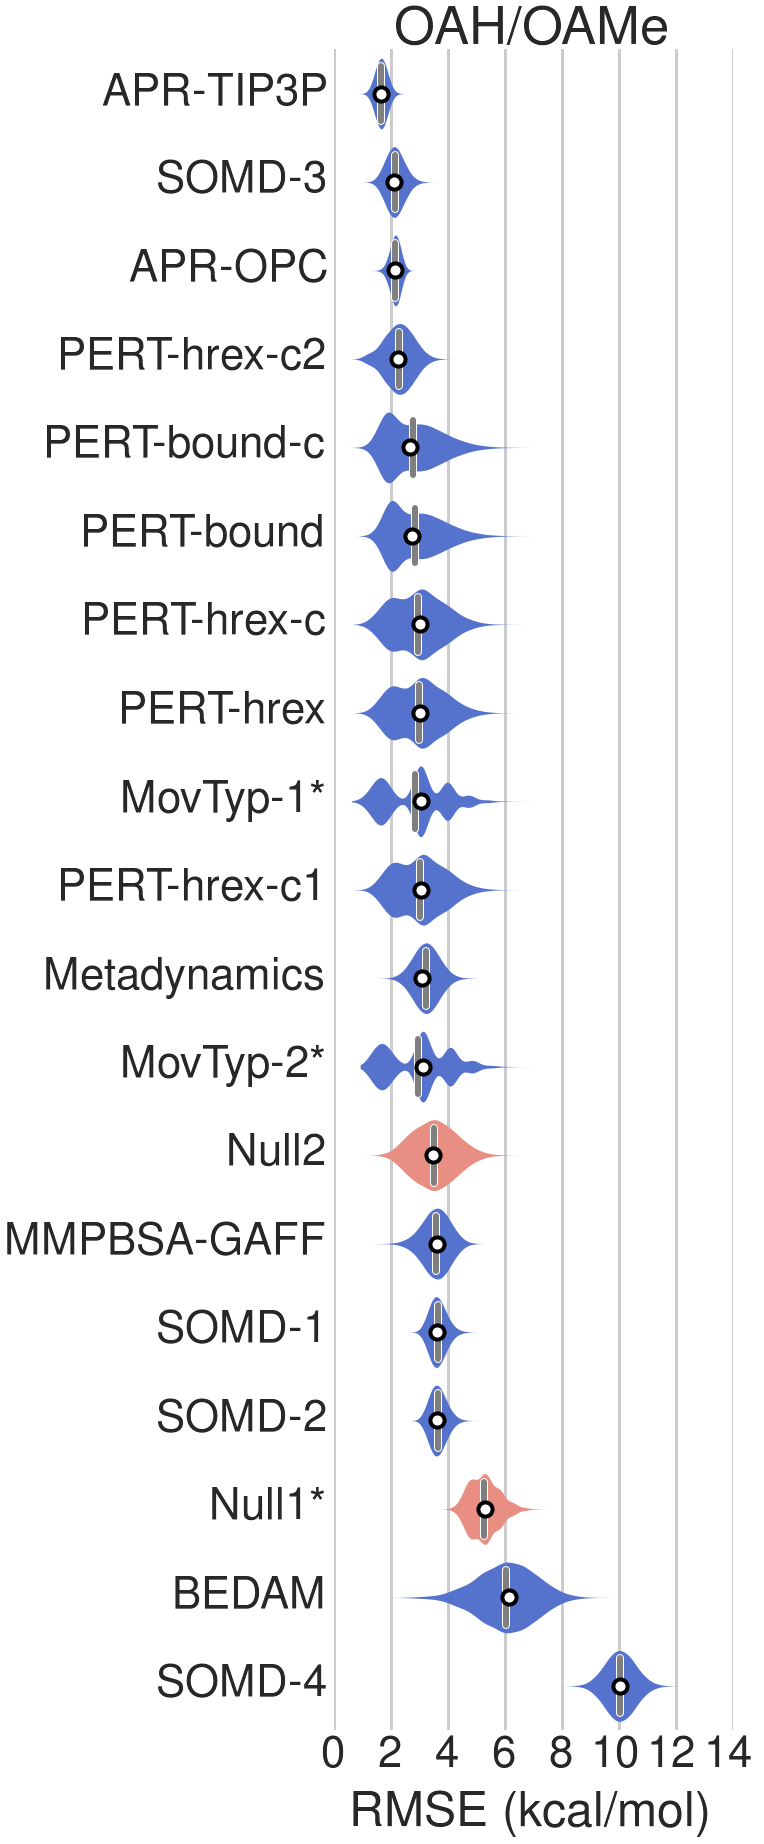

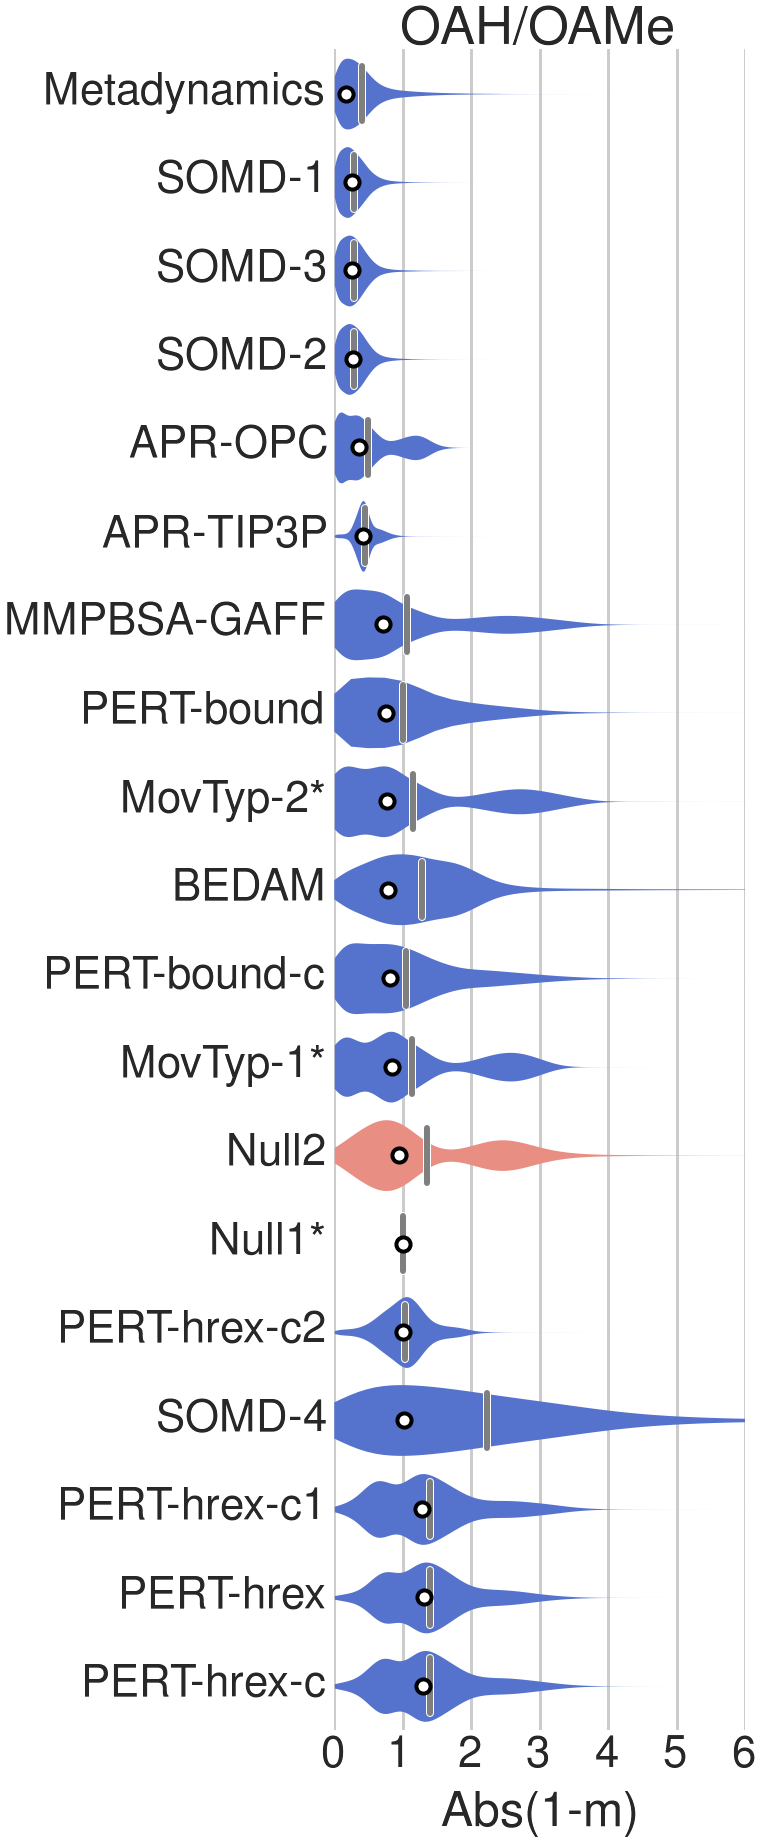

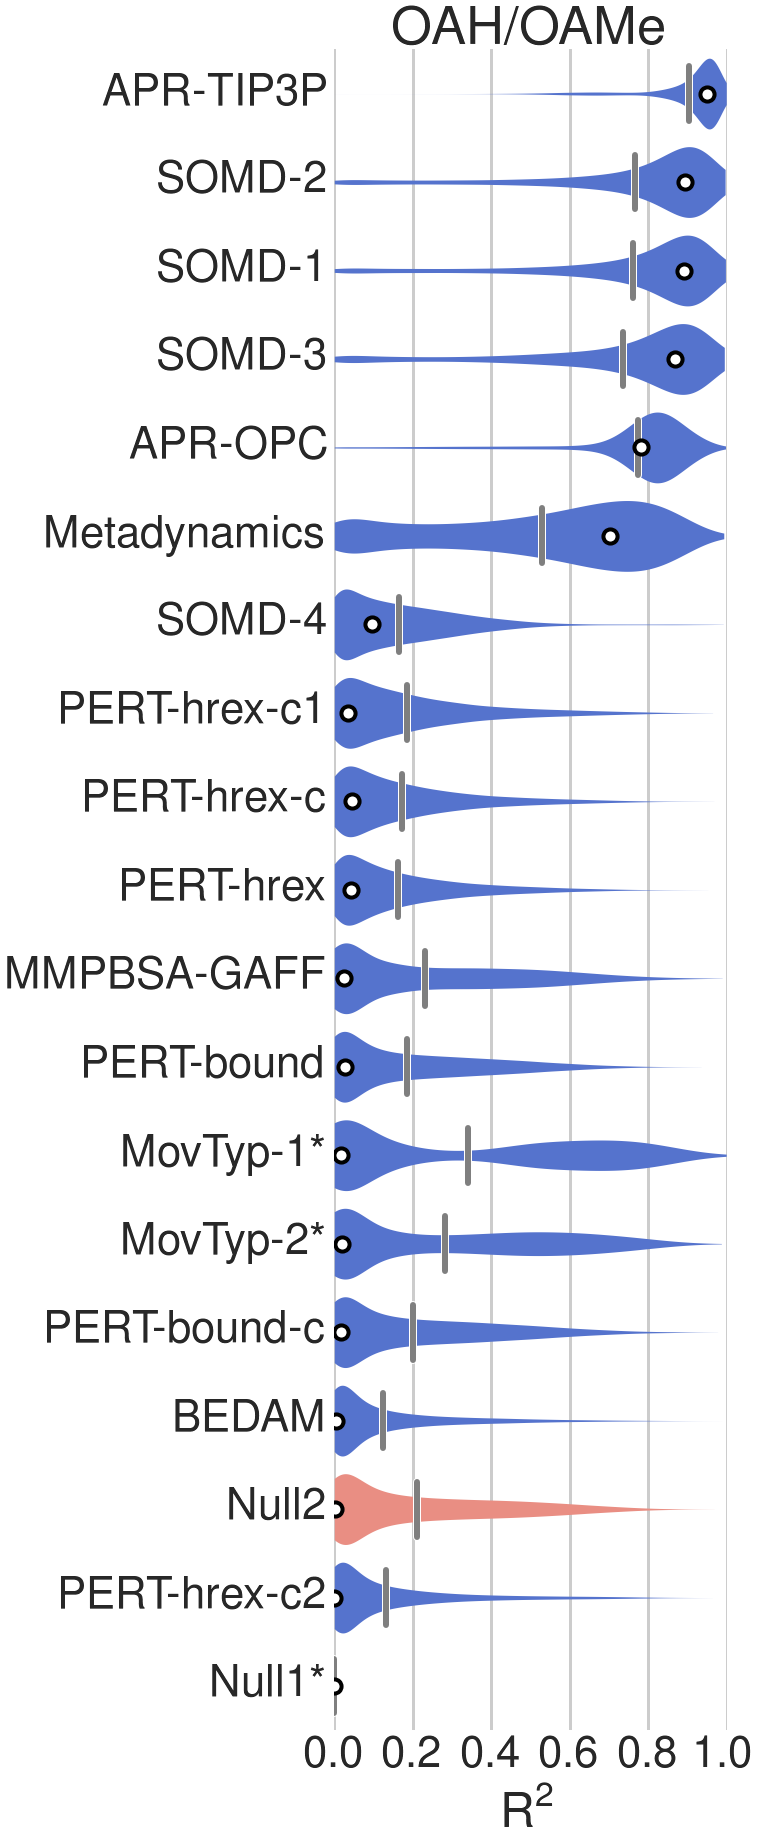

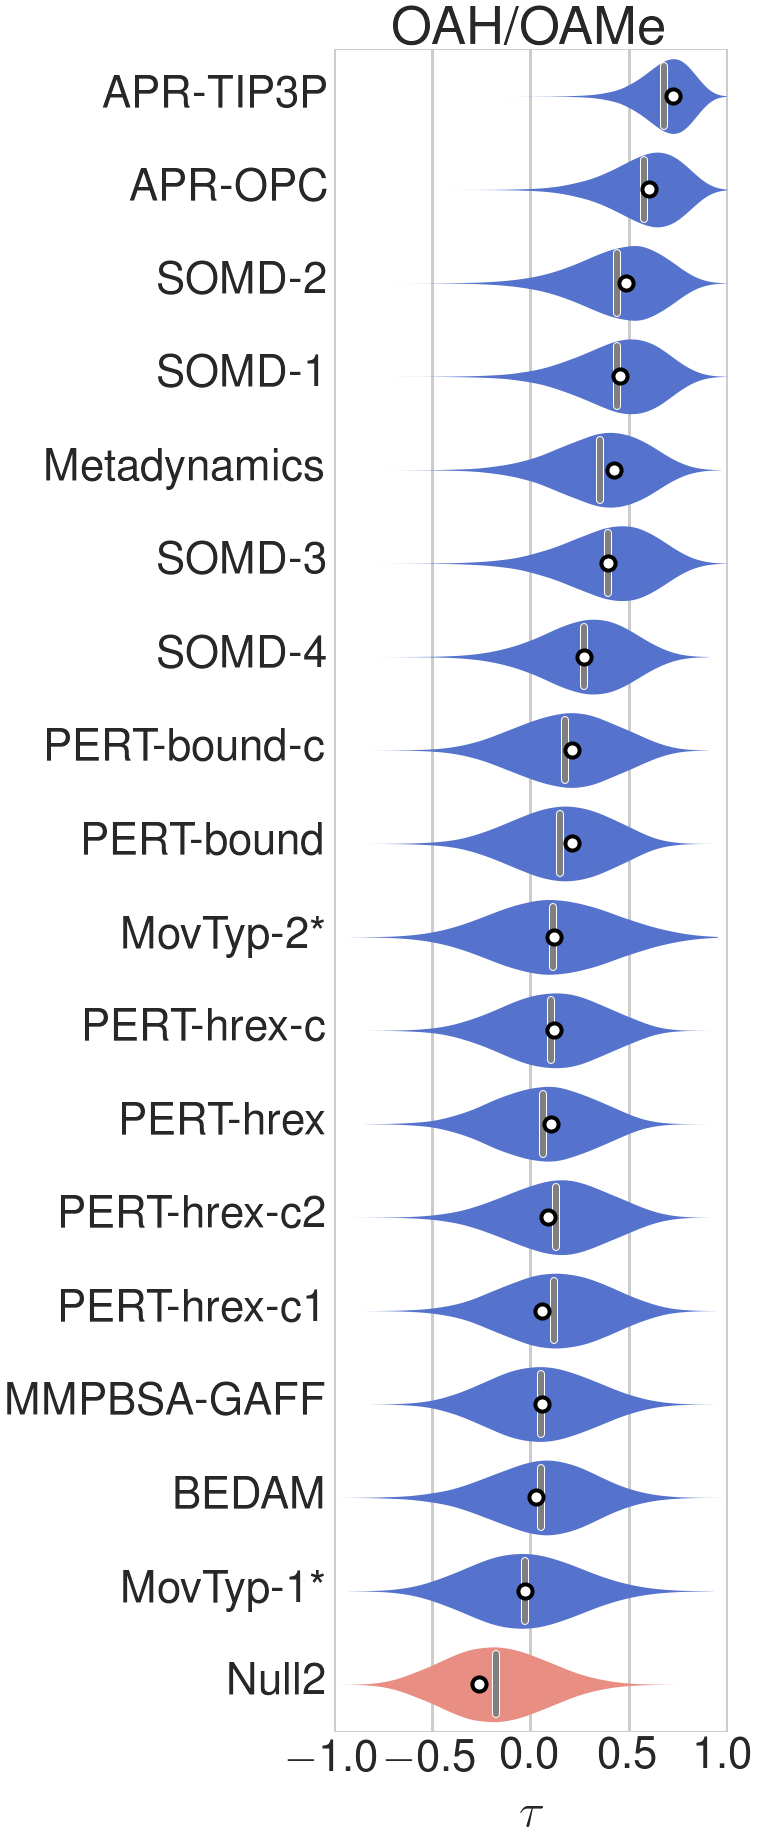

In [8]:
#SaltDep-Abs
os.chdir(run_location+'/Calc-OA')
string = 'ka ../Exp/OASaltDep.txt Null1.txt Null2.txt APR-OPC.txt APR-TIP3P.txt BEDAM.txt Metadynamics.txt MMPBSA-GAFF.txt MovTyp-1.txt MovTyp-2.txt PERT-bound-c.txt PERT-bound.txt PERT-hrex-c1.txt PERT-hrex-c2.txt PERT-hrex-c.txt PERT-hrex.txt SOMD-1.txt SOMD-2.txt SOMD-3.txt SOMD-4.txt'
args = string.split()
if run_calculation:
    RawMs, AllMBoot, AllMVals, CalcNames, Nc = compute_bootstrap(args)
    results = [RawMs, AllMBoot, AllMVals, CalcNames, Nc]
    pickle.dump(results, open('OAH-OAMe-absolute.pickle', 'wb'))
results = pickle.load( open('OAH-OAMe-absolute.pickle', 'rb'))
RawMs, AllMBoot, AllMVals, CalcNames, Nc = results
plot_summary_horizontal_narrow(Nc, RawMs, AllMBoot, AllMVals, CalcNames, absolute=True, relative=False, prefix='OAH/OAMe', filename='OAH-OAMe-absolute')


Calculation = 4, best method index = 18, best method name = SOMD-1
Calculation = 0, best method index = 8, best method name = Metadynamics
Calculation = 3, best method index = 17, best method name = PERT-hrex
Calculation = 7, best method index = 1, best method name = Null2


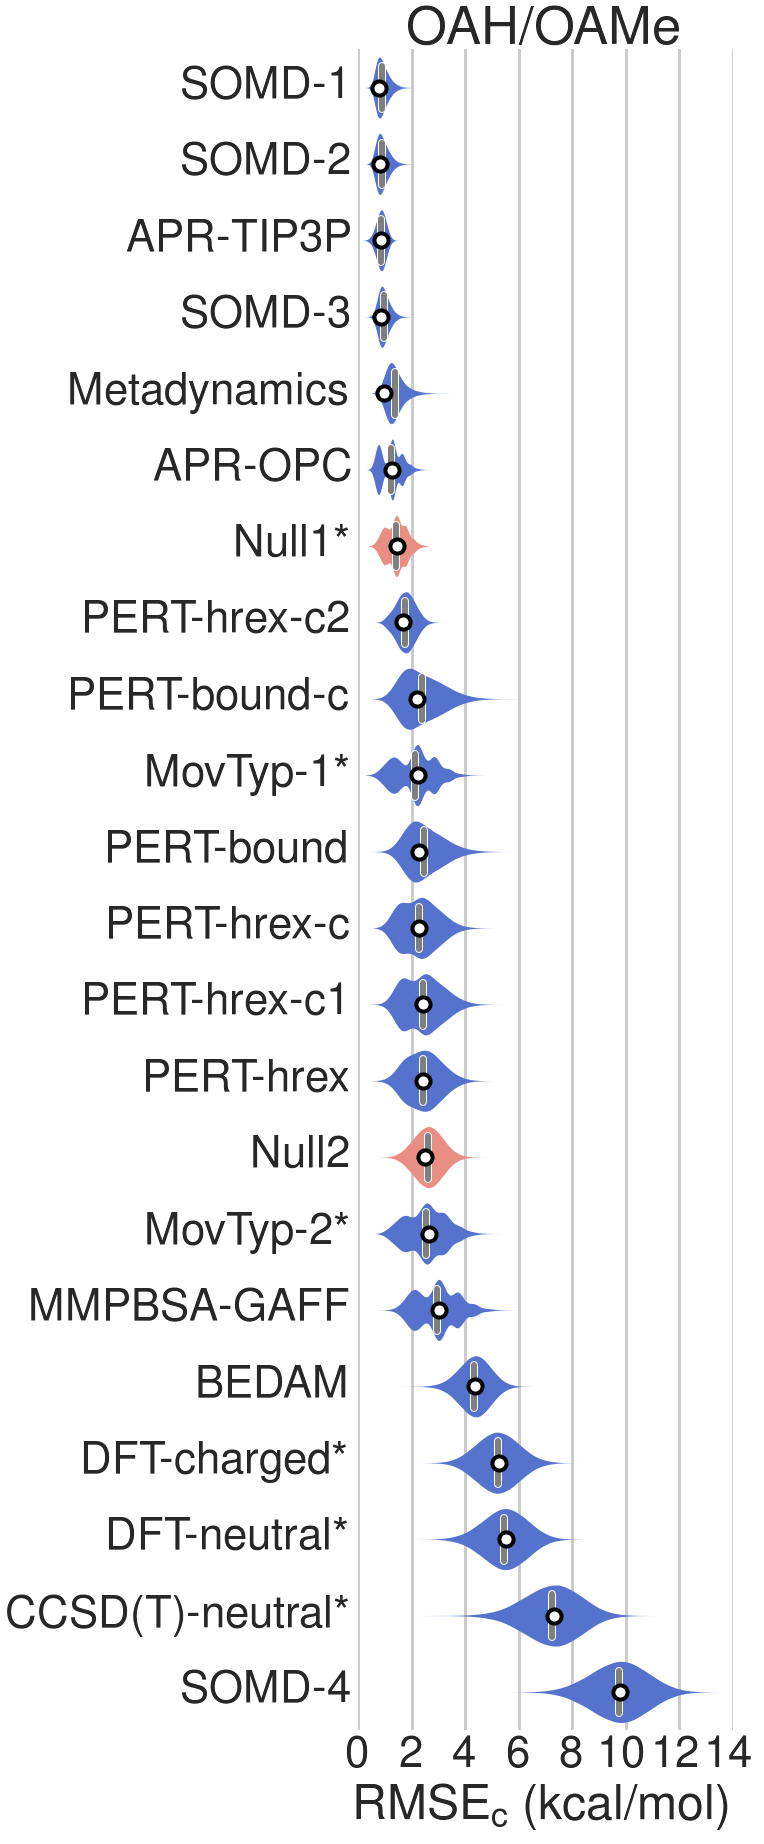

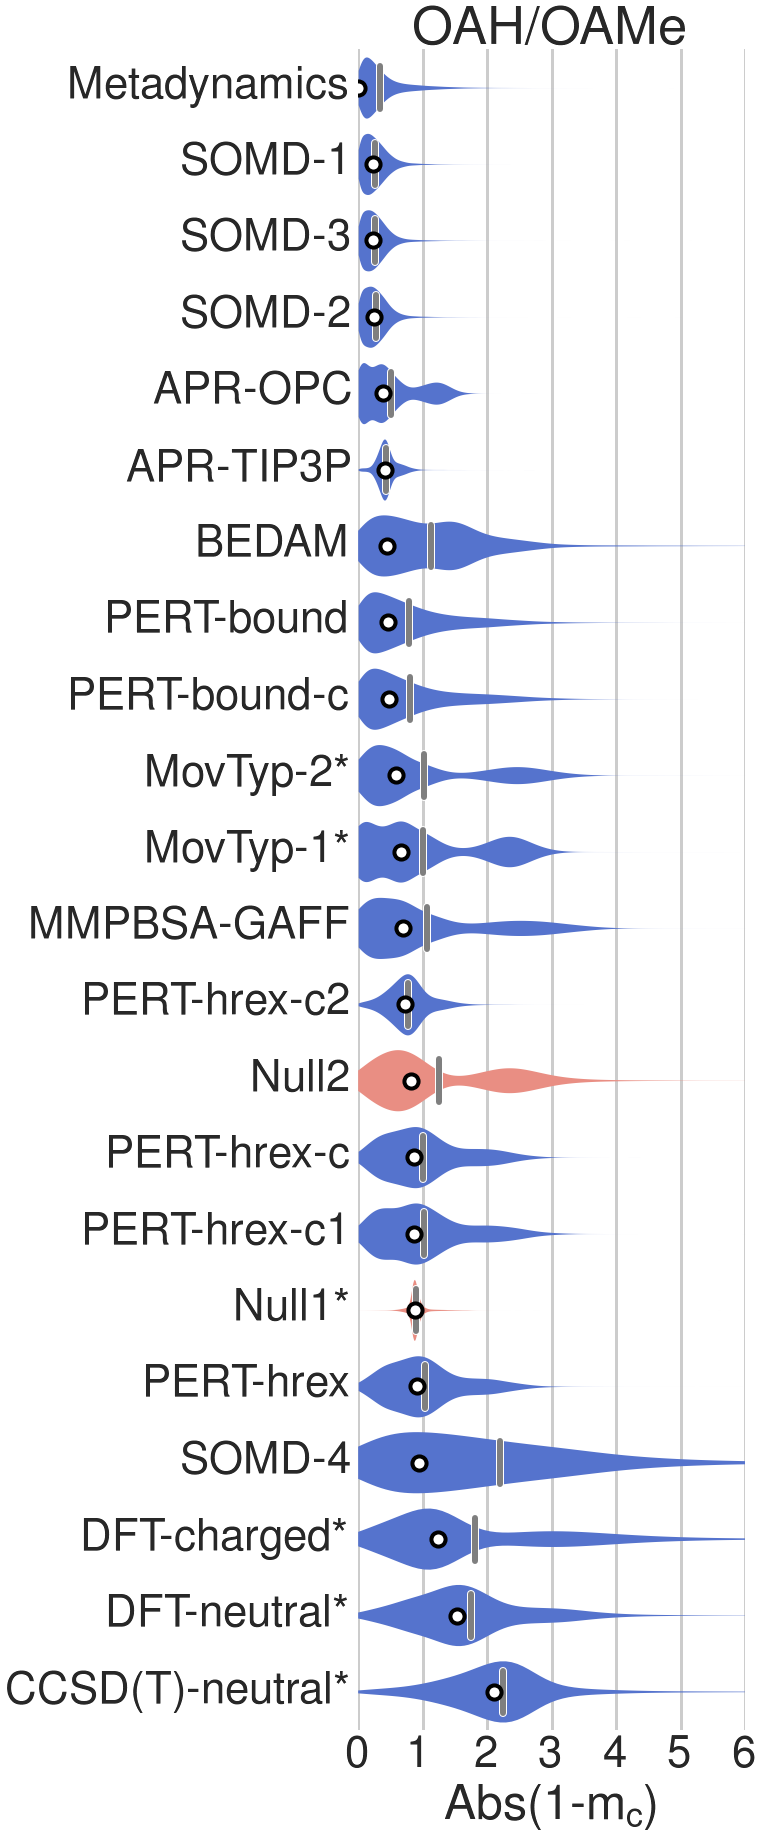

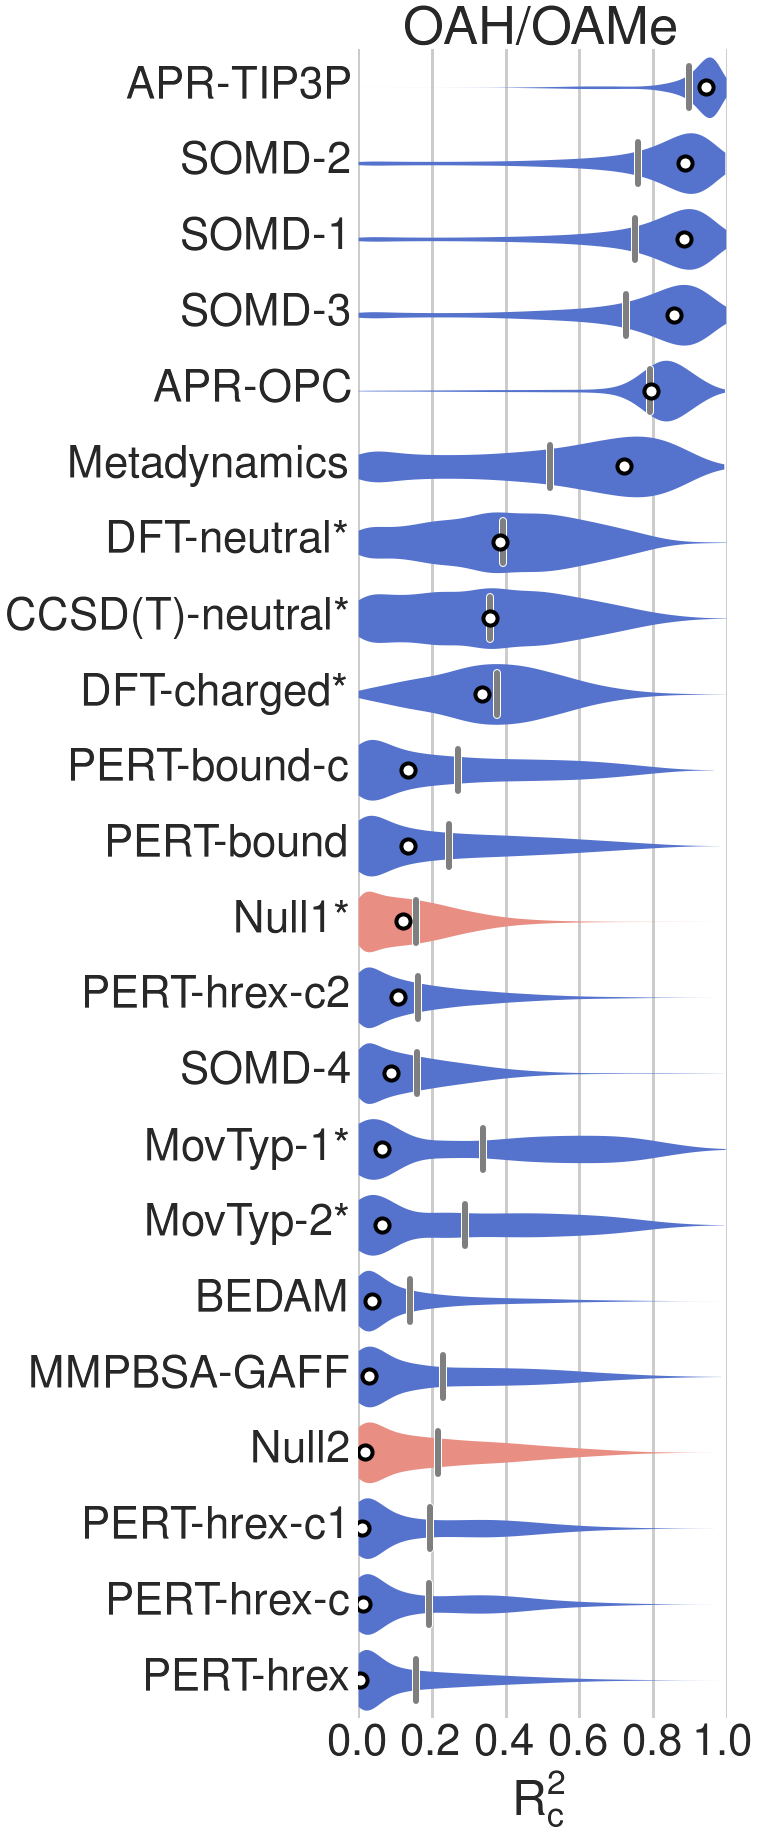

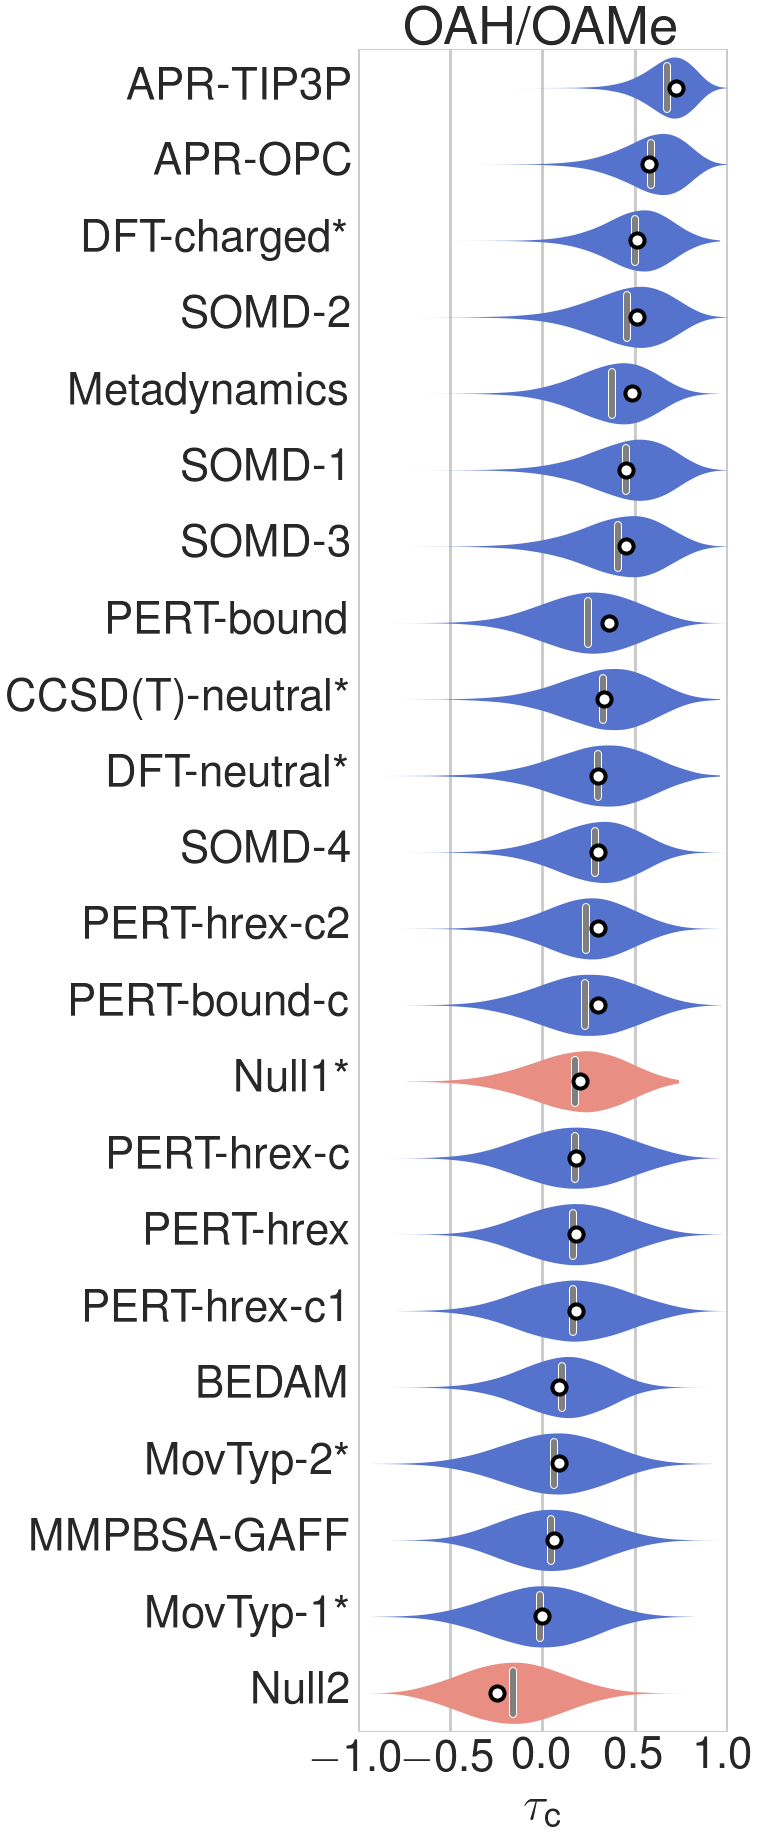

In [9]:
#SaltDep-RelCor
os.chdir(run_location+'/Calc-OA')
string = 'CorrectOA ka ../Exp/OASaltDep.txt Null1.txt Null2.txt APR-OPC.txt APR-TIP3P.txt BEDAM.txt CCSD(T)-neutral.txt DFT-charged.txt DFT-neutral.txt Metadynamics.txt MMPBSA-GAFF.txt MovTyp-1.txt MovTyp-2.txt PERT-bound-c.txt PERT-bound.txt PERT-hrex-c1.txt PERT-hrex-c2.txt PERT-hrex-c.txt PERT-hrex.txt SOMD-1.txt SOMD-2.txt SOMD-3.txt SOMD-4.txt'
args = string.split()
if run_calculation:
    RawMs, AllMBoot, AllMVals, CalcNames, Nc = compute_bootstrap(args)
    results = [RawMs, AllMBoot, AllMVals, CalcNames, Nc]
    pickle.dump(results, open('OAH-OAMe-relative.pickle', 'wb'))
results = pickle.load( open('OAH-OAMe-relative.pickle', 'rb'))
RawMs, AllMBoot, AllMVals, CalcNames, Nc = results
plot_summary_horizontal_narrow(Nc, RawMs, AllMBoot, AllMVals, CalcNames, absolute=False, relative=True, prefix='OAH/OAMe', filename='OAH-OAMe-relative')


Calculation = 4, best method index = 1, best method name = Null2
Calculation = 0, best method index = 1, best method name = Null2
Calculation = 3, best method index = 0, best method name = Null1*
Calculation = 7, best method index = 3, best method name = BAR-dock


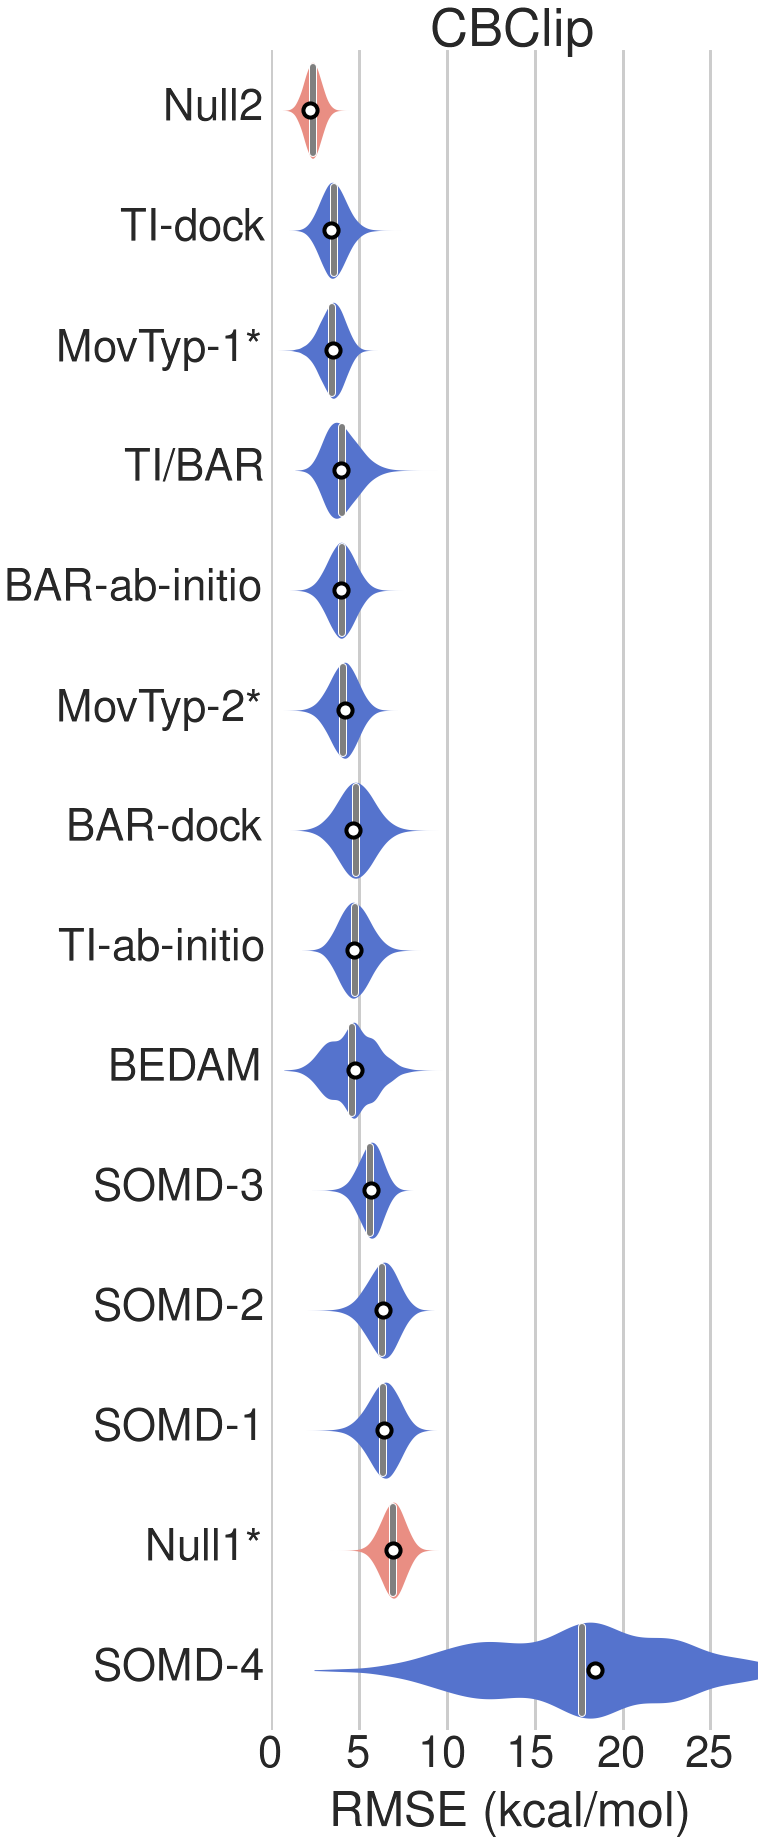

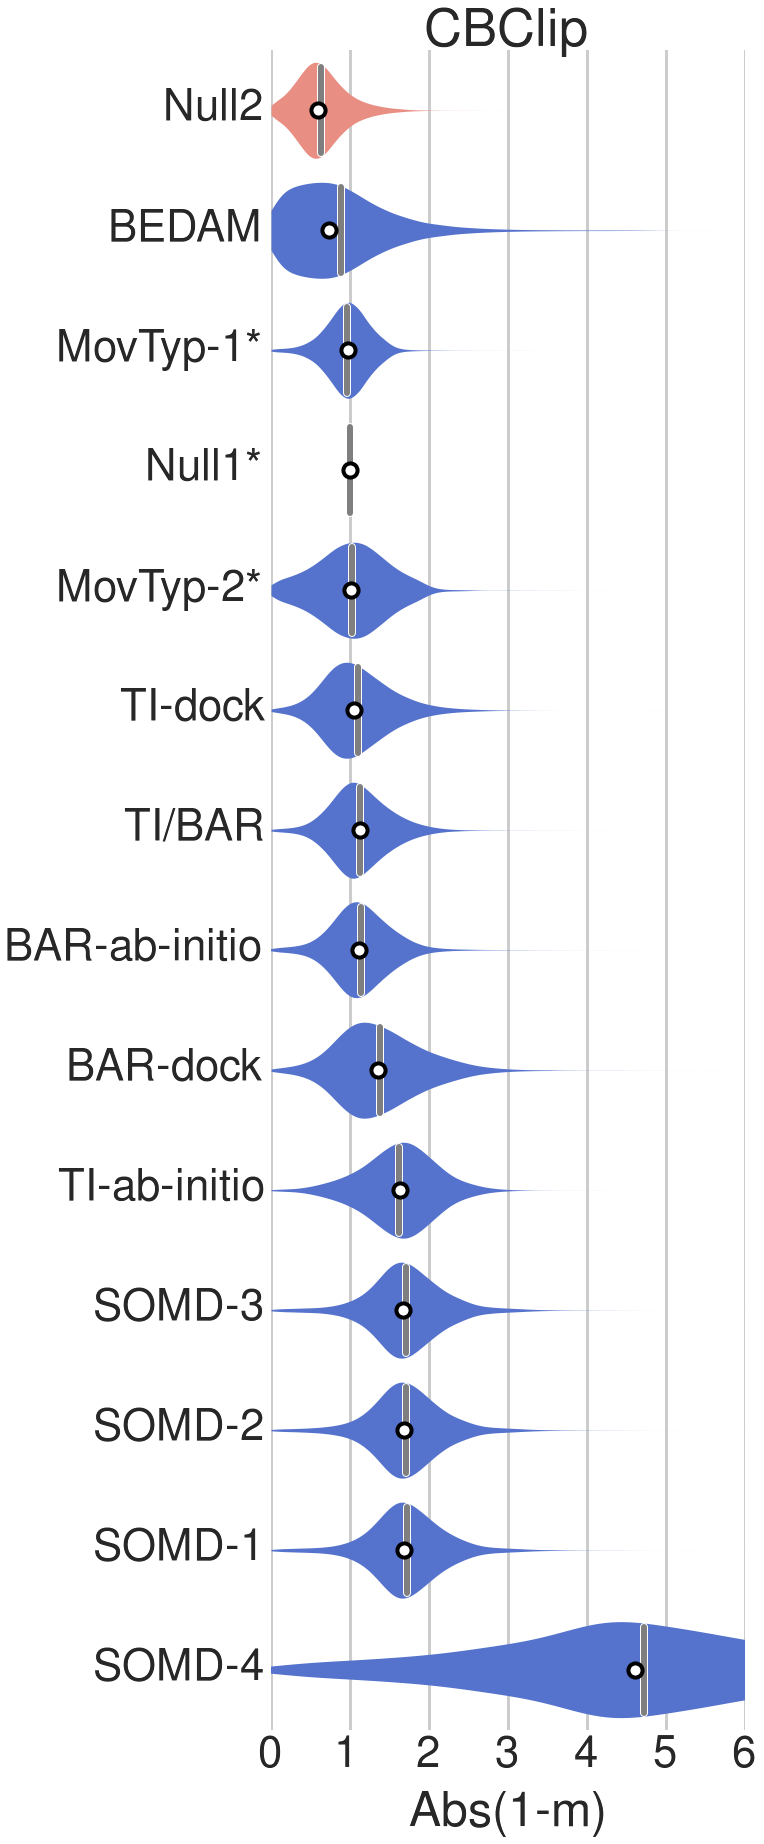

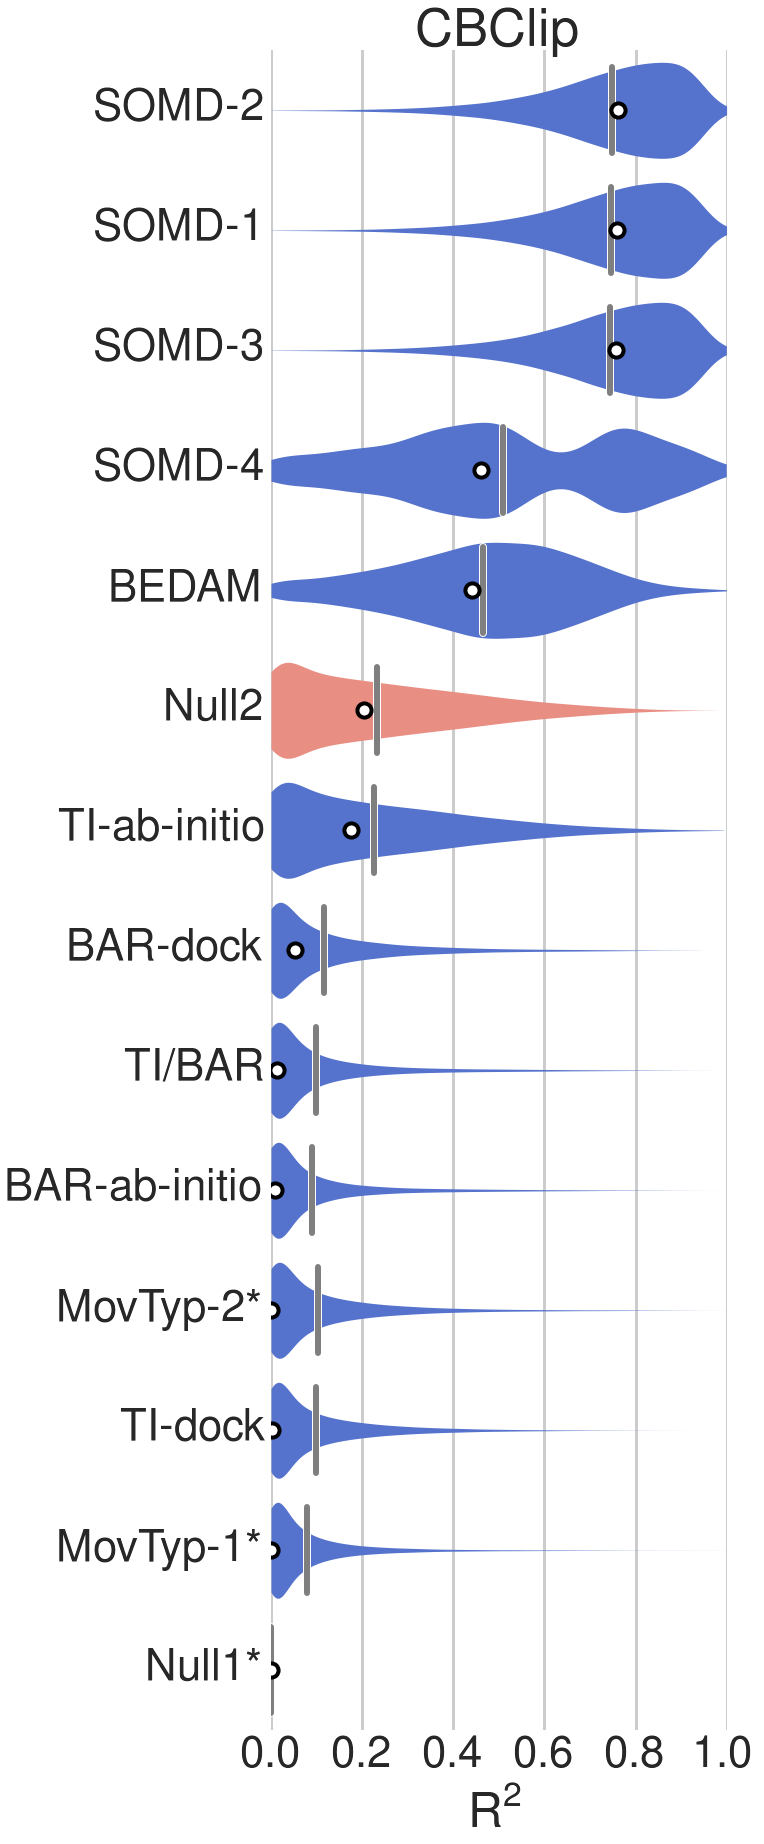

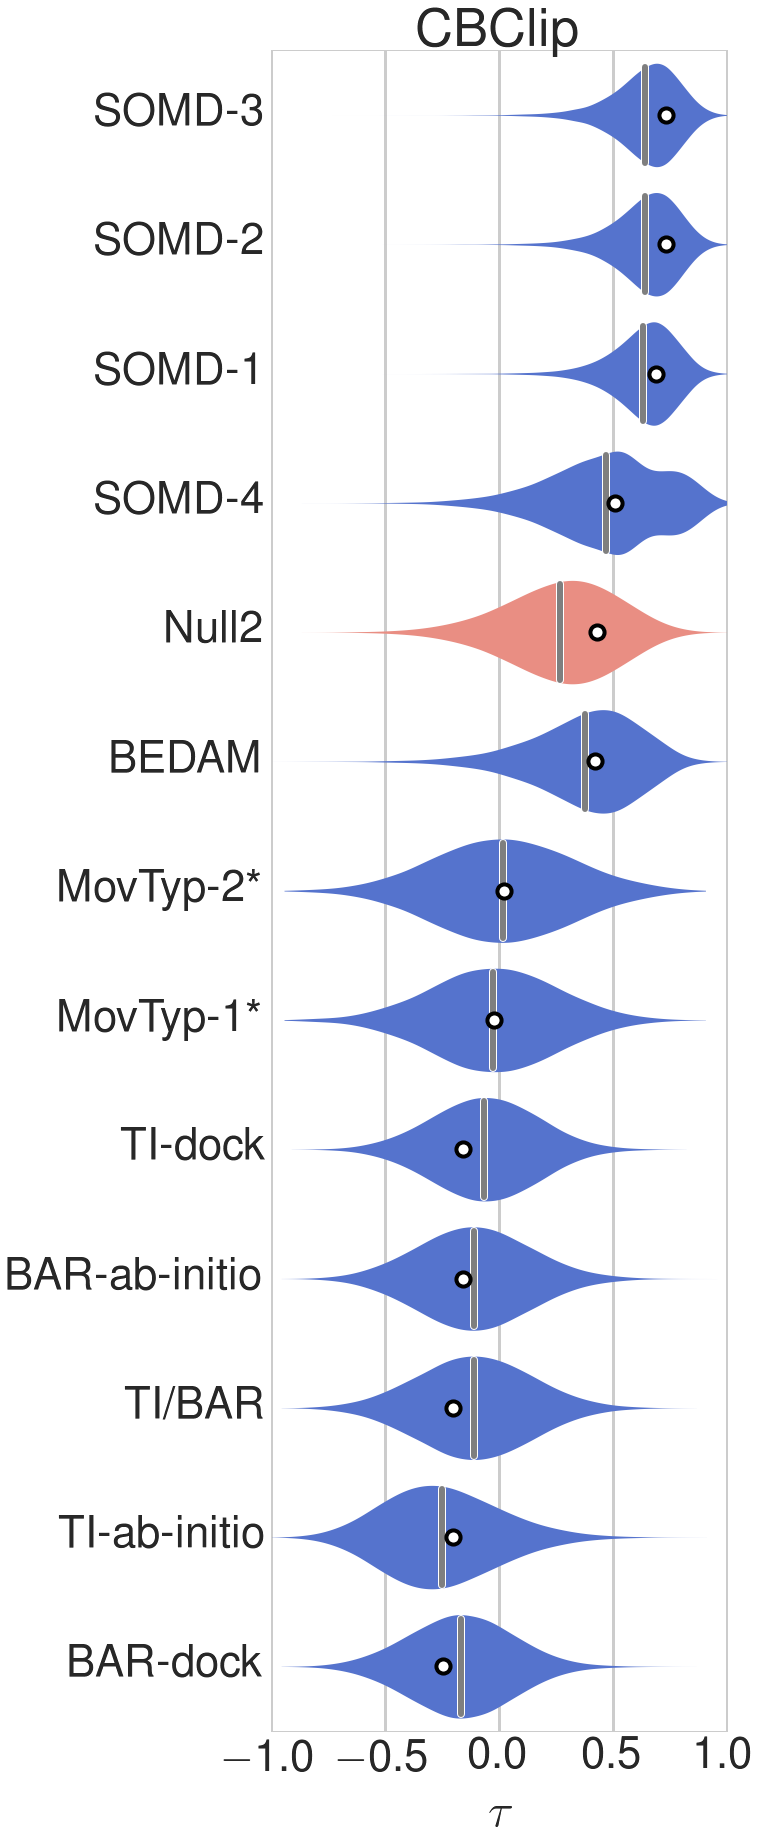

In [10]:
#CBClip-Abs
os.chdir(run_location+'/Calc-CB')
string = 'ka ../Exp/CBClip.txt Null1.txt Null2.txt BAR-ab-initio.txt BAR-dock.txt BEDAM.txt MovTyp-1.txt MovTyp-2.txt SOMD-1.txt SOMD-2.txt SOMD-3.txt SOMD-4.txt TI-ab-initio.txt TI-dock.txt TIxBar.txt'
args = string.split()
if run_calculation:
    RawMs, AllMBoot, AllMVals, CalcNames, Nc = compute_bootstrap(args)
    results = [RawMs, AllMBoot, AllMVals, CalcNames, Nc]
    pickle.dump(results, open('CBClip-absolute.pickle', 'wb'))
results = pickle.load( open('CBClip-absolute.pickle', 'rb'))
RawMs, AllMBoot, AllMVals, CalcNames, Nc = results
plot_summary_horizontal_narrow(Nc, RawMs, AllMBoot, AllMVals, CalcNames, absolute=True, relative=False, prefix='CBClip', filename='CBClip-absolute')